In [34]:
import pandas as pd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import numpy as np

In [35]:
df = pd.read_csv('finaldataset.csv')


In [45]:
df.drop('priceForHDP', axis = 1, inplace = True)

In [47]:
# df.head()

In [46]:
# list(df.columns)

In [42]:
# Gathering the types of each column and appending BigQuery datatype to list
type_list = []

for column in df.columns:
    if df[column].dtype == 'object':
        type_list.append("STRING")
    elif df[column].dtype == 'float64':
        type_list.append("FLOAT64")
    else:
        type_list.append("INTEGER")

In [13]:
# Gathering every column name
field_list = list(df.columns)

In [2]:
# https://www.rudderstack.com/guides/how-to-access-and-query-your-bigquery-data-using-python-and-r/
from google.cloud import bigquery
from google.oauth2 import service_account

In [3]:
# Key.json contains information for service account to connect to BigQuery API
credentials = service_account.Credentials.from_service_account_file('key.json')
project_id = 'zillow-houses-376821'
client = bigquery.Client(credentials = credentials, project = project_id)

In [14]:
# https://medium.com/pipeline-a-data-engineering-resource/automate-your-bigquery-schema-definitions-with-5-lines-of-python-7a1996749718
# Automate schema creation

def create_schema(field_list:list, type_list:list):
    schema_list = []
    for fields, types in zip(field_list, type_list):
        schema = bigquery.SchemaField(fields, types)
        schema_list.append(schema)
    return schema_list

In [ ]:
# Manual schema creation

# schema = [
#     bigquery.SchemaField("zpid", "INTEGER"),
#     bigquery.SchemaField("streetAddress", "STRING"),
#     bigquery.SchemaField("zipcode", "STRING"),
#     bigquery.SchemaField("city", "STRING"),
#     bigquery.SchemaField("state","STRING"),
#     bigquery.SchemaField("latitude", "NUMERIC"),
#     bigquery.SchemaField("longitude", "NUMERIC"),
#     bigquery.SchemaField("price", "INTEGER"),
#     bigquery.SchemaField("bathrooms", "FLOAT64"),
#     bigquery.SchemaField("bedrooms", "FLOAT64"),
#     bigquery.SchemaField("livingArea", "FLOAT64"),
#     bigquery.SchemaField("homeType", "STRING"),
#     bigquery.SchemaField("taxAssessedValue", "FLOAT64"),
#     bigquery.SchemaField("brokerName", "STRING")
# ]

In [45]:
# create_schema(field_list,type_list)

In [39]:
# Function to load dataframe into BigQuery

def bq_load(df, dataset_id: str, table_id: str, schema, client):
    bq_client = client
    dataset_ref = bq_client.dataset(dataset_id)
    dataset_table_id = dataset_ref.table(table_id)
    
    job_config = bigquery.LoadJobConfig()
    job_config.write_disposition='WRITE_TRUNCATE'
    job_config.source_format = bigquery.SourceFormat.CSV
    job_config.autodetect=False
    # Calling create_schema()
    job_config.schema = schema
    job_config.ignore_unknown_values=False
    job = client.load_table_from_dataframe(df,
    table_id,
    location='US',
    job_config=job_config)
    
    return job.result()

In [43]:
df_to_bq = bq_load(df, "zillow_houses", "zillow-houses-376821.zillow_houses.vancouverhouses", create_schema(field_list,type_list), client)

In [48]:
# Testing query

initial_query = """ 

SELECT distinct homeType FROM `zillow-houses-376821.zillow_houses.vancouverhouses`

"""

query_results = client.query(initial_query).to_dataframe()

print(query_results)

        homeType
0            LOT
1      APARTMENT
2          CONDO
3      TOWNHOUSE
4   MULTI_FAMILY
5  SINGLE_FAMILY


In [87]:
from shapely.geometry.polygon import LinearRing, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd

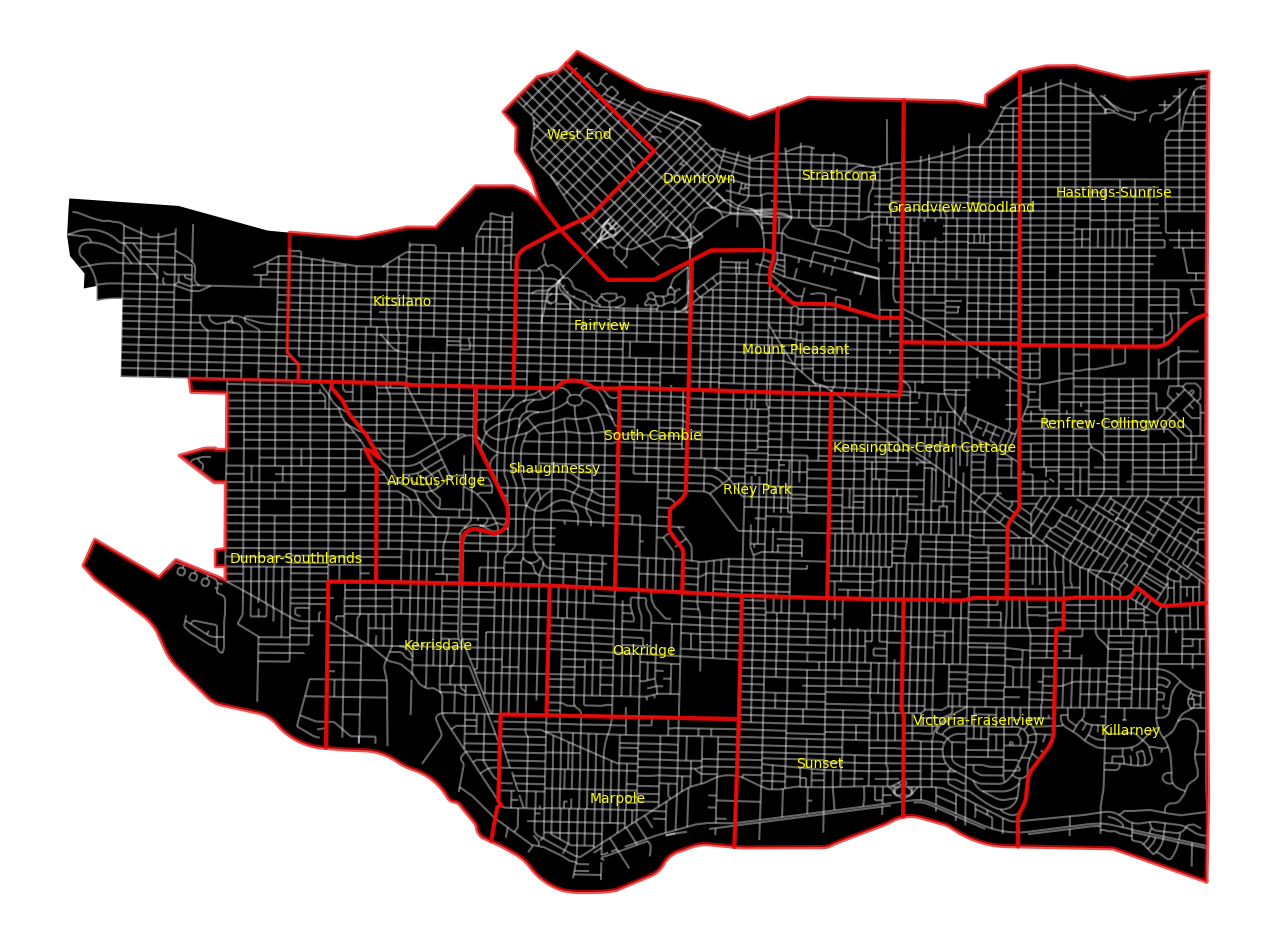

In [64]:
# adapted from https://medium.com/python-in-plain-english/mapping-with-pythons-geopandas-2869bb758b08

bnd_gdf = gpd.read_file('local-area-boundary/local-area-boundary.shp')
ps_gdf = gpd.read_file('public-streets/public-streets.shp')

poly = bnd_gdf['geometry']

locations = poly.apply(lambda x: x.representative_point().coords[:])
locations = [coords[0] for coords in locations]

# x,y = poly.exterior[0].xy

fig, ax = plt.subplots(1, figsize = (30,12))

bnd_gdf.plot(ax = ax, color = 'black')
ps_gdf.plot(ax = ax, color = 'white', alpha = 0.4)
ax.axis('off')

for i in range(len(poly) - 1):
        x,y = poly.exterior[i].xy
        plt.plot(x, y, color='#eb0707', alpha=0.7,
            linewidth=3, solid_capstyle='round', zorder=2)
        plt.annotate(text = bnd_gdf['name'][i], xy = locations[i], c = 'yellow',
                 horizontalalignment='center', fontsize = 10)


In [58]:
# testy,testx = df['latitude'].iloc[0],df['longitude'].iloc[0]

In [99]:
# testdf = df

In [120]:
# df.head(15)

In [119]:
# testdf.head(15)

In [129]:
# test_series = df[df['longitude'].isna()]['streetAddress']
# test_series[test_series.str.contains('#')==False]

97     1011 Cordova St W PENTHOUSE 2
443                   4418 Cambie St
456    889 Pacific St PENTHOUSE 3902
463                   332 E 50th Ave
470                   3496 W 8th Ave
491                   4536 Quebec St
500                    7621 Yukon St
545                  1208 E 15th Ave
609                3536 Sawmill Cres
666         1480 Howe St PENTHOUSE 7
675                   4165 Miller St
679                   988 E 10th Ave
695                  3870 W 26th Ave
713                     2731 Duke St
730                  4351 W 16th Ave
749                 5559 Stamford St
776         1480 Howe St PENTHOUSE 5
789                383 Hastings St E
Name: streetAddress, dtype: object

In [132]:
newaddressList = []

for i in range(len(df['streetAddress'])):
    textaddress = df['streetAddress'].iloc[i]
    newAddress = textaddress.split('#', 1)[0]
    newAddress = newAddress.split('PENTHOUSE', 1)[0]
    newaddressList.append(newAddress)

df['newAddress'] = newaddressList

In [136]:
unknown_address = []

for i in range(0,300):
    y,x = df['latitude'].iloc[i],df['longitude'].iloc[i]

    if np.isnan(y) == True or np.isnan(x) == True:
        address = df['newAddress'].iloc[i]+ ' ' + df['city'].iloc[i]+ ' ' + df['state'].iloc[i]
        geolocator = Nominatim(user_agent="Barry")
        location = geolocator.geocode(address)
        try:
            df.at[i,'latitude'] = location.latitude
            df.at[i,'longitude'] = location.longitude
        except:
            unknown_address.append(df['newAddress'].iloc[i])

In [141]:
for i in range(300, 338):
    y,x = df['latitude'].iloc[i],df['longitude'].iloc[i]

    if np.isnan(y) == True or np.isnan(x) == True:
        address = df['newAddress'].iloc[i]+ ' ' + df['city'].iloc[i]+ ' ' + df['state'].iloc[i]
        geolocator = Nominatim(user_agent="Barry")
        location = geolocator.geocode(address)
        try:
            df.at[i,'latitude'] = location.latitude
            df.at[i,'longitude'] = location.longitude
        except:
            unknown_address.append(df['newAddress'].iloc[i])

In [149]:
for i in range(339, 553):
    y,x = df['latitude'].iloc[i],df['longitude'].iloc[i]

    if np.isnan(y) == True or np.isnan(x) == True:
        address = df['newAddress'].iloc[i]+ ' ' + df['city'].iloc[i]+ ' ' + df['state'].iloc[i]
        geolocator = Nominatim(user_agent="Barry")
        location = geolocator.geocode(address)
        try:
            df.at[i,'latitude'] = location.latitude
            df.at[i,'longitude'] = location.longitude
        except:
            unknown_address.append(df['newAddress'].iloc[i])

In [165]:
for i in range(554, 800):
    y,x = df['latitude'].iloc[i],df['longitude'].iloc[i]

    if np.isnan(y) == True or np.isnan(x) == True:
        address = df['newAddress'].iloc[i]+ ' ' + df['city'].iloc[i]+ ' ' + df['state'].iloc[i]
        geolocator = Nominatim(user_agent="Barry")
        location = geolocator.geocode(address)
        try:
            df.at[i,'latitude'] = location.latitude
            df.at[i,'longitude'] = location.longitude
        except:
            unknown_address.append(df['newAddress'].iloc[i])

In [158]:
messed_up_latitude = 49.2823281
messed_up_longitude = -123.1021128
i = 338
df.at[i,'latitude'] = messed_up_latitude
df.at[i,'longitude'] = messed_up_longitude
i = 553
df.at[i,'latitude'] = messed_up_latitude
df.at[i,'longitude'] = messed_up_longitude

In [170]:
# https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon

# checking every latitude and longitude to determine what neighbourhood house resides in
neighbourhood_name = []
for i in range(len(df['latitude'])):
    checker = 0
    y,x = df['latitude'].iloc[i],df['longitude'].iloc[i]

    if np.isnan(y) == True or np.isnan(x) == True:
        neighbourhood_name.append(np.nan)

    else:
        for name, poly in zip(bnd_gdf['name'],bnd_gdf['geometry']):
            point = Point(x,y)
            if poly.contains(point) == True:
                neighbourhood_name.append(name)
                checker = 1
        if checker != 1:
            neighbourhood_name.append(np.nan)
            

In [172]:
df['neighbourhoodName'] = neighbourhood_name

In [173]:
df.to_csv('reviseddataset.csv', index = False)

In [174]:
df.head()

,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,taxAssessedValue,lotAreaValue,brokerName,neighbourhoodName,newAddress
0,314350313,977 W 20th Ave,V5Z1Y4,Vancouver,BC,49.253757,-123.126560,2899000.0,3.0,5.0,2602.0,SINGLE_FAMILY,2401300.0,3920.4,Sutton Centre Realty Brokerage,South Cambie,977 W 20th Ave
1,2062918487,6 W 17th Ave #7,V5Y1Z4,Vancouver,BC,49.256273,-123.148524,1575000.0,2.0,2.0,1238.0,TOWNHOUSE,NaN,0.0,Dexter Realty Brokerage,Shaughnessy,6 W 17th Ave
2,314365747,623 Victoria Dr,V5L4H3,Vancouver,BC,49.270275,-123.065610,1299000.0,2.0,3.0,1202.0,TOWNHOUSE,1164000.0,0.0,Oakwyn Realty Ltd. Brokerage,Grandview-Woodland,623 Victoria Dr
3,2062918419,6 W 17th Ave #12,V5Y1Z4,Vancouver,BC,49.256273,-123.148524,1725000.0,2.0,1.0,1358.0,TOWNHOUSE,NaN,0.0,Dexter Realty Brokerage,Shaughnessy,6 W 17th Ave
4,2062918471,6 W 17th Ave #2,V5Y1Z4,Vancouver,BC,49.256273,-123.148524,1980000.0,2.0,2.0,1558.0,TOWNHOUSE,NaN,0.0,Dexter Realty Brokerage,Shaughnessy,6 W 17th Ave
